
### CSC 4260/5260: Advanced Data Science & Applications
### Spring 2024 Project: Team 4
### Project Name: 2019 AiportDelays w/Weather and Aiport Details
### By: Anurag Dwivedi, Evan Burch, Jonathan Hooper

Problem Statement: The primary objective of this analysis is to develop a binary classification model that predicts whether a flight will experience a departure delay. This predictive model aims to identify potential delays based on a range of flight and airport-specific variables. The significance of this model lies in its potential to aid airlines, airport authorities, and passengers in anticipating delays, thereby enhancing the efficiency of flight operations and improving the overall travel experience.  

## Importing any necessary libraries!

In [ ]:
!pip install ydata-profiling
!pip install networkx
!pip install pandas scikit-learn imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=ddfceaa5fce8b962565945c697e9f07e0f343fb0ca191bbba76fc8b8681a7896
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,precision_score,recall_score,accuracy_score
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import networkx as nx
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

## Collecting the data from Kaggle

We load the full dataset here

In [ ]:
# Read the CSV file from the unzipped directory
data = pd.read_csv('full_data_flightdelay.csv')
#train_data = pd.read_csv('train.csv')
full_data = data[["MONTH","DAY_OF_WEEK","DEP_TIME_BLK","DISTANCE_GROUP","CONCURRENT_FLIGHTS","NUMBER_OF_SEATS","CARRIER_NAME","AVG_MONTHLY_PASS_AIRLINE","FLT_ATTENDANTS_PER_PASS","DEPARTING_AIRPORT","PRCP","SNOW","SNWD","TMAX","AWND","DEP_DEL15","AIRPORT_FLIGHTS_MONTH","AIRLINE_FLIGHTS_MONTH","GROUND_SERV_PER_PASS","PLANE_AGE"]]

##Exploratory Data Analysis

Here we generate an initial summary of the full dataset and use it to create boxplots to visuzlize the data distribution.

In [ ]:
summary = full_data.describe()
print(summary)

              MONTH   DAY_OF_WEEK  DISTANCE_GROUP  CONCURRENT_FLIGHTS  \
count  6.489062e+06  6.489062e+06    6.489062e+06        6.489062e+06   
mean   6.607062e+00  3.935598e+00    3.821102e+00        2.783675e+01   
std    3.396853e+00  1.995200e+00    2.382233e+00        2.151060e+01   
min    1.000000e+00  1.000000e+00    1.000000e+00        1.000000e+00   
25%    4.000000e+00  2.000000e+00    2.000000e+00        1.100000e+01   
50%    7.000000e+00  4.000000e+00    3.000000e+00        2.300000e+01   
75%    1.000000e+01  6.000000e+00    5.000000e+00        3.900000e+01   
max    1.200000e+01  7.000000e+00    1.100000e+01        1.090000e+02   

       NUMBER_OF_SEATS  AVG_MONTHLY_PASS_AIRLINE  FLT_ATTENDANTS_PER_PASS  \
count     6.489062e+06              6.489062e+06             6.489062e+06   
mean      1.337397e+02              7.814970e+06             9.753707e-05   
std       4.645213e+01              5.046882e+06             8.644459e-05   
min       4.400000e+01            

Next, we use the ProfileReport function to create a comprehensive html report. This report reveals many of the same facts that will be discovered below, and is a powerful EDA tool. The resulting report.html can be viewed in the GitHub repository.

In [ ]:
#commented out so it does not run
#report = ProfileReport(full_data, title = "report", explorative=True)
#report.to_file("report.html")

Here we use the head function to take a peek at the first 5 rows. This allows us to ses what the attributes look like

In [ ]:
full_data.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,DEPARTING_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DEP_DEL15,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,GROUND_SERV_PER_PASS,PLANE_AGE
0,1,7,0800-0859,2,25,143,Southwest Airlines Co.,13382999,0.000062,McCarran International,0.0,0.0,0.0,65.0,2.91,0,13056,107363,0.000099,8
1,1,7,0700-0759,7,29,191,Delta Air Lines Inc.,12460183,0.000144,McCarran International,0.0,0.0,0.0,65.0,2.91,0,13056,73508,0.000149,3
2,1,7,0600-0659,7,27,199,Delta Air Lines Inc.,12460183,0.000144,McCarran International,0.0,0.0,0.0,65.0,2.91,0,13056,73508,0.000149,18
3,1,7,0600-0659,9,27,180,Delta Air Lines Inc.,12460183,0.000144,McCarran International,0.0,0.0,0.0,65.0,2.91,0,13056,73508,0.000149,2
4,1,7,0001-0559,7,10,182,Spirit Air Lines,2688839,0.000009,McCarran International,0.0,0.0,0.0,65.0,2.91,0,13056,15023,0.000125,1


In [ ]:
#train_data.head()

Next, we check for any missing and null values with the isna function

In [ ]:
#checking for any missing values
missing_values_count = full_data.isna().sum()
print("Number of missing values in each column:")
print(missing_values_count)

Number of missing values in each column:
MONTH                       0
DAY_OF_WEEK                 0
DEP_TIME_BLK                0
DISTANCE_GROUP              0
CONCURRENT_FLIGHTS          0
NUMBER_OF_SEATS             0
CARRIER_NAME                0
AVG_MONTHLY_PASS_AIRLINE    0
FLT_ATTENDANTS_PER_PASS     0
DEPARTING_AIRPORT           0
PRCP                        0
SNOW                        0
SNWD                        0
TMAX                        0
AWND                        0
DEP_DEL15                   0
AIRPORT_FLIGHTS_MONTH       0
AIRLINE_FLIGHTS_MONTH       0
GROUND_SERV_PER_PASS        0
PLANE_AGE                   0
dtype: int64


In [ ]:
#checking for any null values
full_data.isnull().sum()

MONTH                       0
DAY_OF_WEEK                 0
DEP_TIME_BLK                0
DISTANCE_GROUP              0
CONCURRENT_FLIGHTS          0
NUMBER_OF_SEATS             0
CARRIER_NAME                0
AVG_MONTHLY_PASS_AIRLINE    0
FLT_ATTENDANTS_PER_PASS     0
DEPARTING_AIRPORT           0
PRCP                        0
SNOW                        0
SNWD                        0
TMAX                        0
AWND                        0
DEP_DEL15                   0
AIRPORT_FLIGHTS_MONTH       0
AIRLINE_FLIGHTS_MONTH       0
GROUND_SERV_PER_PASS        0
PLANE_AGE                   0
dtype: int64

Next, we analyze the dimensionality of the dataset by looking at the data types of our attributes

In [ ]:
#looking at the data types
full_data.dtypes

MONTH                         int64
DAY_OF_WEEK                   int64
DEP_TIME_BLK                 object
DISTANCE_GROUP                int64
CONCURRENT_FLIGHTS            int64
NUMBER_OF_SEATS               int64
CARRIER_NAME                 object
AVG_MONTHLY_PASS_AIRLINE      int64
FLT_ATTENDANTS_PER_PASS     float64
DEPARTING_AIRPORT            object
PRCP                        float64
SNOW                        float64
SNWD                        float64
TMAX                        float64
AWND                        float64
DEP_DEL15                     int64
AIRPORT_FLIGHTS_MONTH         int64
AIRLINE_FLIGHTS_MONTH         int64
GROUND_SERV_PER_PASS        float64
PLANE_AGE                     int64
dtype: object

Here is the shape and size of the dataset for reference

In [ ]:
full_data.shape

(6489062, 20)

In [ ]:
full_data.size

129781240

Next, we take a look at our target attribute, DEP_DEL15, which is either 1 or 0. This indicates whether or not the flight in question was delayed by more than 15 minutes.

We can see that there is a disparity here in our data. There are many more non-delayed flights than delayed flights.

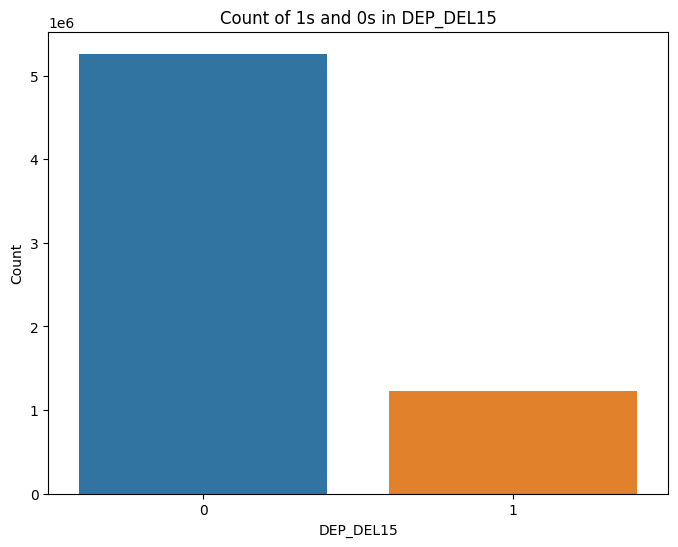

In [ ]:
column_to_plot = 'DEP_DEL15'

plt.figure(figsize=(8, 6))
sns.countplot(data=full_data, x=column_to_plot)
plt.title('Count of 1s and 0s in ' + column_to_plot)
plt.xlabel(column_to_plot)
plt.ylabel('Count')
plt.show()

In [ ]:
# check the distribution
full_data['DEP_DEL15'].value_counts()/full_data.shape[0]

DEP_DEL15
0    0.810856
1    0.189144
Name: count, dtype: float64

Next, we eliminate attributes CARRIER_NAME and PREVIOUS_AIRPORT, as they are not likely to be helpful to our models

In [ ]:
columns_to_ignore = ['CARRIER_NAME', 'PREVIOUS_AIRPORT', 'DEP_TIME_BLK', 'DEPARTING_AIRPORT']
full_filtered = full_data.drop(columns=columns_to_ignore, errors='ignore')

Next, we create a correlation matrix to see if there are any immediately obvious attributes that correlate with a delayed departure.

Nothing stands out as noteworthy. Although there may be some attributes that correlate with each other because they are similar in their purpose.

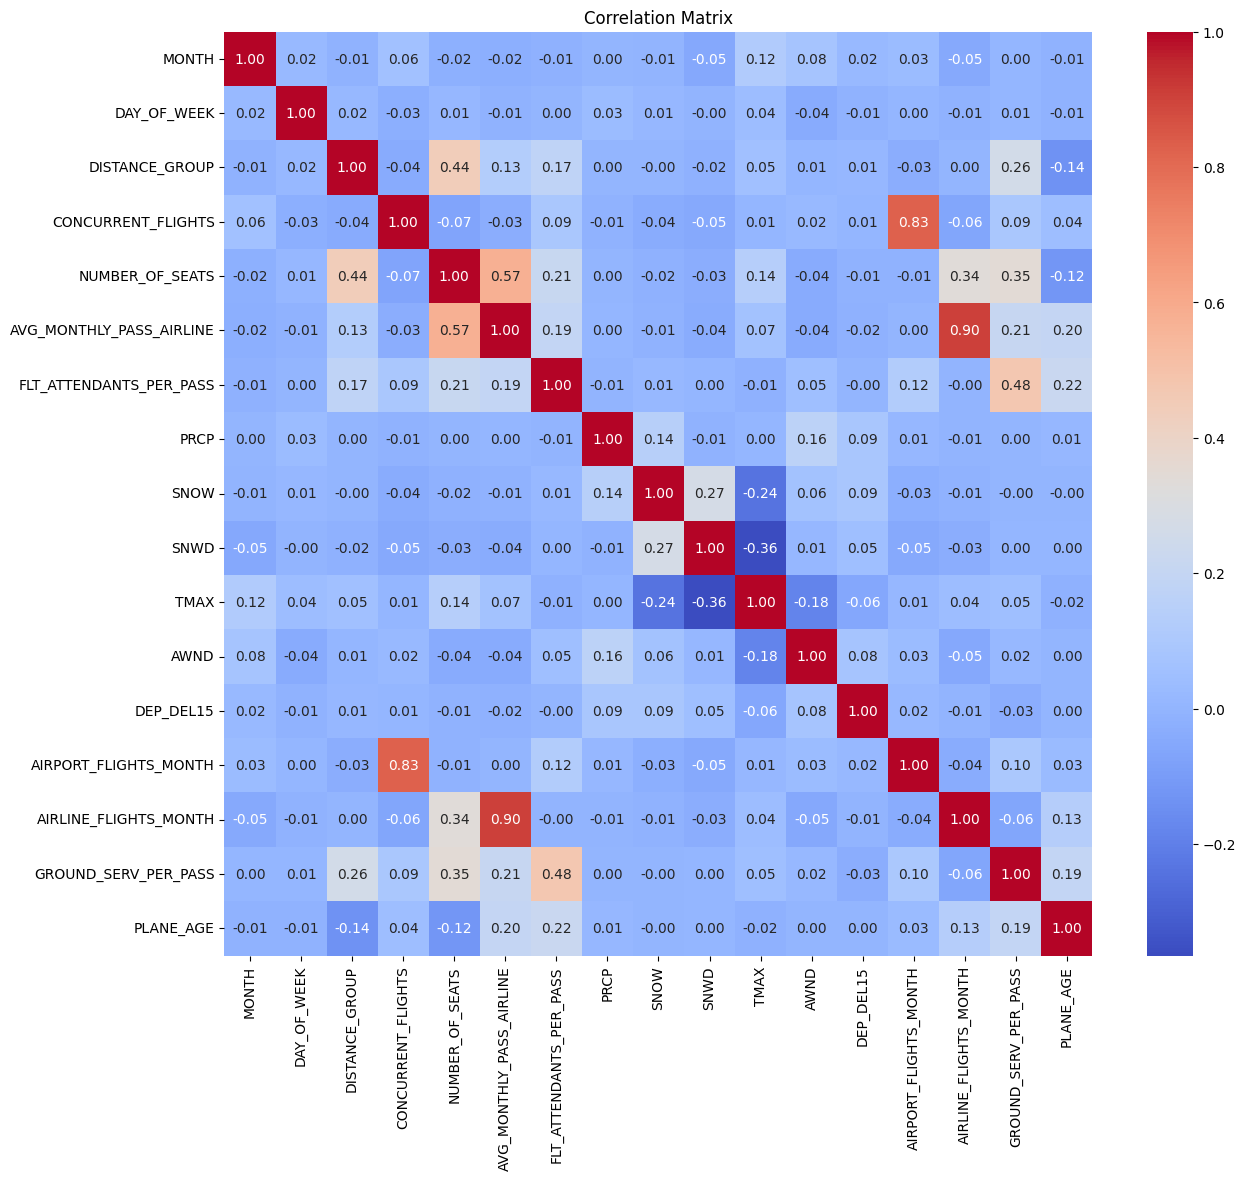

In [ ]:
correlation_train = full_filtered.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Data Cleaning and Wrangling

Next, we drop all rows that contain NAs. The number of rows with NAs is not many so it should not have a statistical effect on the dataset.

In [ ]:
full_data_clean = full_data.dropna()
print("Original Shape: ", full_data)
print("Cleaned: ", full_data_clean)

Original Shape:           MONTH  DAY_OF_WEEK DEP_TIME_BLK  DISTANCE_GROUP  CONCURRENT_FLIGHTS  \
0            1            7    0800-0859               2                  25   
1            1            7    0700-0759               7                  29   
2            1            7    0600-0659               7                  27   
3            1            7    0600-0659               9                  27   
4            1            7    0001-0559               7                  10   
...        ...          ...          ...             ...                 ...   
1048570      3            7    2000-2059              10                  25   
1048571      3            7    0800-0859               3                  33   
1048572      3            7    1800-1859               7                  26   
1048573      3            7    0800-0859              11                  33   
1048574      3            7    1900-1959               5                  25   

         NUMBER_OF_SEA

In [ ]:
# encode the categorical data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

# clean the labels
list_of_labels = ['CARRIER_NAME', 'DEP_TIME_BLK', 'DEPARTING_AIRPORT']
full_data_encoded = clean_labels_encoder(list_of_labels, full_data)

# show head of the dataset
full_data_encoded.head()

<ipython-input-11-833ca8b0df86>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = le.fit_transform(df[label])
<ipython-input-11-833ca8b0df86>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = le.fit_transform(df[label])
<ipython-input-11-833ca8b0df86>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,DEPARTING_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DEP_DEL15,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,GROUND_SERV_PER_PASS,PLANE_AGE
0,1,7,3,2,25,143,14,13382999,0.000062,44,0.0,0.0,0.0,65.0,2.91,0,13056,107363,0.000099,8
1,1,7,2,7,29,191,6,12460183,0.000144,44,0.0,0.0,0.0,65.0,2.91,0,13056,73508,0.000149,3
2,1,7,1,7,27,199,6,12460183,0.000144,44,0.0,0.0,0.0,65.0,2.91,0,13056,73508,0.000149,18
3,1,7,1,9,27,180,6,12460183,0.000144,44,0.0,0.0,0.0,65.0,2.91,0,13056,73508,0.000149,2
4,1,7,0,7,10,182,15,2688839,0.000009,44,0.0,0.0,0.0,65.0,2.91,0,13056,15023,0.000125,1


In [ ]:
x = full_data_encoded[["MONTH","DAY_OF_WEEK","DISTANCE_GROUP","AVG_MONTHLY_PASS_AIRLINE","AIRPORT_FLIGHTS_MONTH","AIRLINE_FLIGHTS_MONTH","PLANE_AGE","GROUND_SERV_PER_PASS","PRCP","SNOW","SNWD","TMAX","AWND","DEP_TIME_BLK","CARRIER_NAME","DEPARTING_AIRPORT","CONCURRENT_FLIGHTS","NUMBER_OF_SEATS","FLT_ATTENDANTS_PER_PASS"]]
y = full_data_encoded["DEP_DEL15"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [ ]:
X_train_df = pd.DataFrame(X_train)
X_train_df.head()

,MONTH,DAY_OF_WEEK,DISTANCE_GROUP,AVG_MONTHLY_PASS_AIRLINE,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,GROUND_SERV_PER_PASS,PRCP,SNOW,SNWD,TMAX,AWND,DEP_TIME_BLK,CARRIER_NAME,DEPARTING_AIRPORT,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,FLT_ATTENDANTS_PER_PASS
3340566,7,3,2,13382999,3445,117728,16,0.000099,0.00,0.0,0.0,75.0,7.38,7,14,56,8,143,0.000062
201780,1,4,2,1204766,13375,23760,17,0.000107,0.00,0.0,0.0,35.0,22.82,7,3,37,30,44,0.000348
1179234,3,5,3,473794,27137,12510,18,0.000200,0.00,0.0,0.0,34.0,5.82,7,4,11,57,50,0.000000
4760524,9,6,3,12460183,31713,81338,26,0.000149,0.00,0.0,0.0,87.0,9.84,11,6,4,41,157,0.000144
5885136,11,7,1,12460183,13199,79989,3,0.000149,0.02,0.0,0.0,47.0,10.74,17,6,17,23,180,0.000144


# Logistic Regression

In [ ]:
'''rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))'''

Accuracy: 0.5284362110483275
              precision    recall  f1-score   support

           0       0.81      0.54      0.65    169492
           1       0.20      0.48      0.28     40223

    accuracy                           0.53    209715
   macro avg       0.51      0.51      0.46    209715
weighted avg       0.70      0.53      0.58    209715



In [ ]:
'''smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))'''


Accuracy: 0.5171923801349451
              precision    recall  f1-score   support

           0       0.82      0.52      0.64    169492
           1       0.20      0.50      0.29     40223

    accuracy                           0.52    209715
   macro avg       0.51      0.51      0.46    209715
weighted avg       0.70      0.52      0.57    209715



In [ ]:
'''smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))'''

In [ ]:
from imblearn.over_sampling import RSMOTE
rsmote = RSMOTE(random_state=42)
X_resampled, y_resampled = rsmote.fit_resample(X_train, y_train)

logreg = LogisticRegression()
logreg.fit(X_resampled, y_resampled)

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy*100)

In [ ]:
f1 = f1_score(y_test, pred)
print("F1 Score:", f1)

In [ ]:
auc_roc = roc_auc_score(y_test, pred)
print("ROC:", auc_roc)

## Weighted Logistic Regression

In [ ]:
# Fit a weighted logistic regression model
weights = {0: 19, 1: 81}  # Weight 81 for class 1 (minority class)
weighted_lr_model = LogisticRegression(random_state=42, class_weight=weights)
weighted_lr_model.fit(X_train, y_train)

# Make predictions with the weighted model
y_pred_weighted_lr = weighted_lr_model.predict(X_test)

# Evaluate the weighted model
print("Weighted Logistic Regression:")
print(classification_report(y_test, y_pred_weighted_lr))

Weighted Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.81      1.00      0.90   1052178
           1       0.00      0.00      0.00    245635

    accuracy                           0.81   1297813
   macro avg       0.41      0.50      0.45   1297813
weighted avg       0.66      0.81      0.73   1297813



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#performance metrics for weighted logistic regression
accuracy_weighted_lr = accuracy_score(y_test, y_pred_weighted_lr)
print("Accuracy:", accuracy_weighted_lr*100)
f1_weighted_lr = f1_score(y_test, y_pred_weighted_lr)
print("F1 Score:", f1_weighted_lr)
auc_roc_weighted_lr = roc_auc_score(y_test, y_pred_weighted_lr)
print("ROC:", auc_roc_weighted_lr)

Accuracy: 81.07315923018186
F1 Score: 0.0
ROC: 0.5


# KNN Algorithm

In [ ]:
'''from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score

classifier = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring=scorers, refit=False)
grid_search.fit(X_train, y_train)

best_params_accuracy = grid_search.cv_results_['params'][grid_search.cv_results_['rank_test_accuracy'] == 1][0]
best_params_f1_score = grid_search.cv_results_['params'][grid_search.cv_results_['rank_test_f1_score'] == 1][0]
best_params_roc_auc_score = grid_search.cv_results_['params'][grid_search.cv_results_['rank_test_roc_auc_score'] == 1][0]

print("Best parameters for accuracy:", best_params_accuracy)
print("Best parameters for F1 score:", best_params_f1_score)
print("Best parameters for ROC AUC score:", best_params_roc_auc_score)'''

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

#predicting the test set results
y_pred = classifier.predict(X_test)

#generating confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

#print accuracy score
print("Accuracy with k=5", ac*100)

In [ ]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

In [ ]:
auc_roc = roc_auc_score(y_test, y_pred)
print("ROC:", auc_roc)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker= '*', s=100,edgecolors='black')
plt.title("Predicted values with k=5", fontsize=20)

#plt.subplot(1,2,2)
#plt.scatter(X_test[:,0], X_test[:,1], c=y_pred_1, marker= '*', s=100,edgecolors='black')
#plt.title("Predicted values with k=1", fontsize=20)
#plt.show()

# Decision Tree Classifier


In [ ]:
'''from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

param_grid = {
    'random_state': range(100)
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_random_state = grid_search.best_params_['random_state']
print("Best Random State:", best_random_state)'''

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state = 4, criterion = 'gini')

# Train Decision Tree Classifer
dt.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_dt = dt.predict(X_test)

# Model Accuracy,
print("Accuracy:", accuracy_score(y_test, y_pred_dt)*100)

In [ ]:
f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)

In [ ]:
auc_roc = roc_auc_score(y_test, y_pred_dt)
print("ROC:", auc_roc)

In [ ]:
# let's create a dictionary of features and their importance values
X_train_df = pd.DataFrame(X_train)
feat_dict= {}
for col, val in sorted(zip(X_train_df.columns, dt.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [ ]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

In [ ]:
values = feat_df.Importance
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict delayed departure')
plt.show()